## Importing Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import nltk
import re
import random
import string
from string import punctuation
from nltk.corpus import stopwords # Words which do not contribute to the sentiment analysis
from nltk.tokenize import word_tokenize # Separating sentences in different components, every word and punctuation
from nltk.stem import LancasterStemmer # Converts the words to root words which might or might not make sense
from nltk.corpus import twitter_samples # Load the twitter dataset
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import FreqDist
from nltk import classify
from nltk import NaiveBayesClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from wordcloud import WordCloud, STOPWORDS 

## Reading The Data and Cleaning Pipeline

### Reading The Data

In [2]:
data = pd.read_csv('spam.csv', encoding = 'latin-1')
data = data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1)
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Resampling The Data

### Cleaning Pipeline

In [3]:
def preprocess(words):
    stuff_to_be_removed = list(stopwords.words('english'))+list(punctuation)
    stemmer = LancasterStemmer()
    
    final_corpus = []
    for i in range(len(words)):
        word = word_tokenize(words[i].lower())
        word = [stemmer.stem(y) for y in word if y not in stuff_to_be_removed]
        j = " ".join(word)
        final_corpus.append(j)
    return final_corpus

In [4]:
def remove_noise(tweet_tokens, stop_words = ()):
    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

In [5]:
x = data.v2.tolist()
x = preprocess(remove_noise(x, stopwords.words('english')))
data1 = pd.DataFrame({'data' : x, 'label' : data.v1})
data1.label = data1.label.replace(['ham', 'spam'], [0, 1])
data1.head()

,data,label
0,go jurong point crazy.. avail bug n gre world ...,0
1,ok lar ... jok wif u on ...,0
2,fre entry 2 wkly comp win fa cup fin tkts 21st...,1
3,u dun say ear hor ... u c already say ...,0
4,nah n't think goe usf liv around though,0


## Model Building

### Making a TFIDF Vectorizer

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
x = tfidf.fit_transform(data1['data']).toarray() 
y = data1.label
x.shape

(5572, 6963)

In [7]:
rus = RandomUnderSampler()
x, y = rus.fit_resample(x, y)

### Splitting into Train and Test

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle = True, test_size = 0.2)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(1195, 6963) (299, 6963)
(1195,) (299,)


### Running The Model

#### RandomForestClassifier

In [9]:
rfc = RandomForestClassifier(n_estimators = 100, verbose = 1, n_jobs = 5)
rfc.fit(x_train, y_train)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    1.4s finished


RandomForestClassifier(n_jobs=5, verbose=1)

In [10]:
pred = rfc.predict(x_test)
print('Accuracy Score:', accuracy_score(y_test, pred))
print('Confusion Matrix:')
confusion_matrix(y_test, pred)

Accuracy Score: 0.939799331103679
Confusion Matrix:


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.0s finished


array([[148,   1],
       [ 17, 133]])

#### SVM

In [11]:
svm = LinearSVC(verbose = 2)
svm.fit(x_train, y_train)

[LibLinear]

LinearSVC(verbose=2)

In [12]:
pred = svm.predict(x_test)
print('Accuracy Score:', accuracy_score(y_test, pred))
print('Confusion Matrix:')
confusion_matrix(y_test, pred)

Accuracy Score: 0.9531772575250836
Confusion Matrix:


array([[146,   3],
       [ 11, 139]])

#### Naive Bayes

In [13]:
nb = MultinomialNB()
nb.fit(x_train, y_train)

MultinomialNB()

In [14]:
pred = nb.predict(x_test)
print('Accuracy Score:', accuracy_score(y_test, pred))
print('Confusion Matrix:')
confusion_matrix(y_test, pred)

Accuracy Score: 0.9464882943143813
Confusion Matrix:


array([[140,   9],
       [  7, 143]])

## Visualization of Words Used In Spam Text

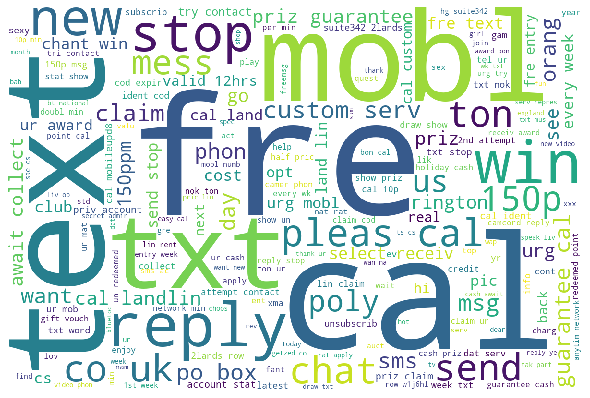

In [15]:
stopwords = set(STOPWORDS) 
comment_words = ''

for val in data1[data1.label == 1].data: 
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens) + " "
  
wordcloud = WordCloud(width = 1200, height = 800, background_color = 'white', stopwords = stopwords, 
                min_font_size = 10).generate(comment_words)
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 15), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()